In [4]:
pip install matplotlib

You should consider upgrading via the 'c:\Users\sneha\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [ ]:
!pip install torchvision 


ERROR: Could not find a version that satisfies the requirement torchvision (from versions: 0.1.6, 0.1.7, 0.1.8, 0.1.9, 0.2.0, 0.2.1, 0.2.2, 0.2.2.post2, 0.2.2.post3)
ERROR: No matching distribution found for torchvision

[notice] A new release of pip available: 22.3 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

import pickle
import torch
import time
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [24]:
PATH_bva = "./data/annotations/20180415_bva.json"
PATH_cyber = "./data/annotations/20180415_cyber_crime.json"
PATH_intellectual = "./data/annotations/20180415_intellectual_property.json"
PATH_scotus = "./data/annotations/20180415_scotus.json"

train_PATHS = [PATH_bva, PATH_intellectual, PATH_scotus]
test_PATHS = [PATH_cyber]

In [25]:
for path_ in train_PATHS:
        dataset = json.load(open(path_, "r", encoding="utf8"))
        for doc in dataset:
            x = dataset[doc]['text']
            y = []
            for sentence in dataset[doc]['annotations']:
                y.append(dataset[doc]['text'][sentence['start']:sentence['end']])
                for i in range(len(y[-1])):
                    if(y[-1][i]=='�'):
                        print(y[-1][i])       

�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�
�


In [26]:
dlimit_final = {}

In [27]:
def filter_delims(x):
    dataset = json.load(open(x, "r", encoding="utf8"))
    for doc in dataset:
        text = dataset[doc]['text'].replace("\r","\n").replace("\t","\n")
        dlimit = {}
        for pos, char in enumerate(text):
            if not char.isalnum():
                dlimit[char]=1
    return dlimit

dlimit_final.update(filter_delims(PATH_bva)) 
dlimit_final.update(filter_delims(PATH_intellectual)) 
dlimit_final.update(filter_delims(PATH_scotus)) 


    

In [28]:
dlimit_final['?']=1

In [29]:
dlimit_final

{' ': 1,
 ':': 1,
 '\n': 1,
 '/': 1,
 '.': 1,
 '-': 1,
 ')': 1,
 ',': 1,
 '(': 1,
 '"': 1,
 "'": 1,
 '�': 1,
 ';': 1,
 '[': 1,
 ']': 1,
 '+': 1,
 '_': 1,
 '§': 1,
 '&': 1,
 '\u2002': 1,
 '\u2003': 1,
 '?': 1,
 '$': 1,
 '*': 1,
 '\x97': 1}

In [30]:
window_size = 6

def dataset_gen(x, window_size=10):
    dataset = json.load(open(x, "r", encoding="utf8"))
    x = []
    y = []

    for doc in dataset:
        text = dataset[doc]['text'].replace("\r","\n").replace("\t","\n")
        ends = []

        for loc in dataset[doc]['annotations']:
            ends.append(loc['end'])

        for pos, char in enumerate(text):
            if char in dlimit_final.keys():
                right = text[pos+1:pos+window_size+1]
                left = text[pos-window_size-1:pos-1]

                if len(right) == 0:
                    right = "\n"+ " "*(window_size-1)

                # elif right.replace(".","")[0] == "\n":
                #     continue
                # elif right[0] == "\n":
                #     right = "\n"+ " "*(window_size-1)

                right = right + " "*(window_size-len(right))
                left = " "*(window_size-len(left)) + left

                x.append([left,char,right])

                if pos+1 in ends:
                    y.append(1) # setence eneded if 1
    
                else:
                    y.append(0) 
    return x, y


test_x,test_y = dataset_gen(test_PATHS[0], window_size=window_size)
train_x, train_y = [], []

for paths in train_PATHS:
    x,y = dataset_gen(paths, window_size=window_size)
    train_x = train_x + x
    train_y = train_y + y

print(len(train_x), len(test_x))

468047 162794


In [31]:
for i,j in zip(train_x, train_y):
    if j == 1:
        print(i)

['ES\n\n\n\n', '.', '  Enti']
['ressio', '.', '\n\n\n\n2.']
['n.\n\n\n\n', '.', '  Enti']
[' (TDIU', '.', '\n\n\n\n\n\n']
['er 197', '.', '\n\n\n\nTh']
[' Orego', '.', '  In D']
['w Judg', '.', '  A tr']
[' recor', '.', '\n\n\n\nIn']
[' ratin', '.', '  The ']
['(Court', '.', '  In S']
[' Motio', '.', '\n\n\n\nTh']
['n (AOJ', '.', '  VA w']
['equire', '.', '\n\n\n\n\n\n']
['e dril', '.', '\n\n\n\nTh']
['of suc', '.', '  The ']
['r 1976', '.', '  The ']
['f slee', '.', '\n\n\n\nTh']
['er 197', '.', '  He w']
['in 197', '.', '  He w']
['er 197', '.', '  He w']
['il 197', '.', '  He s']
['ly 197', '.', '  He s']
['er 197', '.', '  In O']
['tively', '.', '  \n\n\n\n']
['of 3.4', '.', '  He h']
[' of 3.', '.', '  He h']
['of 3.5', '.', '  For ']
[' of 3.', '.', ' \n\n\n\nA']
['ehavio', '.', '  The ']
['iforni', '.', '\n\n\n\nAn']
['re goo', '.', '\n\n\n\nA ']
['of dut', '.', '  Agai']
['osevel', '.', '\n\n\n\nAn']
['of dut', '.', '  \n\n\n\n']
['llowin', ':', '\n\n\n\nSi']
['r plan', '.', ' 

In [32]:
def raw_str(string):
    return string.replace("\n","\\n").replace("\r","\\r").replace("\t","\\t")


dataset = json.load(open(test_PATHS[0], "r", encoding="utf8"))

for doc in dataset:
    text = dataset[doc]['text']
    print(raw_str(text)[:1000])
    break
    

United States v. Barsumyan, 517 F.3d 1154 (9th Cir. 2008)\nCourt of Appeals for the Ninth Circuit\nFiled: February 28th, 2008\nPrecedential Status: Precedential\nCitations: 517 F.3d 1154\nDocket Number: 07-50251\nAuthor: Joseph Jerome Farris\n\n517 F.3d 1154 (2008)\nUNITED STATES of America, Plaintiff-Appellee,\nv.\nAram BARSUMYAN, aka Seal A(1), Defendant-Appellant.\n\nNo. 07-50251.\nUnited States Court of Appeals, Ninth Circuit.\n\nArgued and Submitted January 10, 2008.\nFiled February 28, 2008.\n*1155 Davina T. Chen, Deputy Federal Public Defender, Los Angeles, CA, for the defendant-appellant.\n\nAlexander A. Bustamante and Anne Voights, Assistant United States Attorneys, Major Frauds Section, Los Angeles, CA, for the plaintiff-appellee.\n\nBefore: JEROME FARRIS and MILAN D. SMITH, JR., Circuit Judges, and H. RUSSEL HOLLAND,[*] District Judge.\n\nMILAN D. SMITH, JR., Circuit Judge:\n\nDefendant-Appellant Aram Barsumyan appeals the sentence imposed by the district court following his

In [33]:
i=0
for j in train_y:
    if j==1:
        i+=1

print(i, len(train_y)-i, 100*(i/len(train_y)))

15608 452439 3.3347078391699982


In [34]:
import string

characters = list(' '+string.printable.replace(" ",""))
characters.append('UNK')

characters = {x:i for i, x in enumerate(characters)}

print(len(characters))

characters

101


{' ': 0,
 '0': 1,
 '1': 2,
 '2': 3,
 '3': 4,
 '4': 5,
 '5': 6,
 '6': 7,
 '7': 8,
 '8': 9,
 '9': 10,
 'a': 11,
 'b': 12,
 'c': 13,
 'd': 14,
 'e': 15,
 'f': 16,
 'g': 17,
 'h': 18,
 'i': 19,
 'j': 20,
 'k': 21,
 'l': 22,
 'm': 23,
 'n': 24,
 'o': 25,
 'p': 26,
 'q': 27,
 'r': 28,
 's': 29,
 't': 30,
 'u': 31,
 'v': 32,
 'w': 33,
 'x': 34,
 'y': 35,
 'z': 36,
 'A': 37,
 'B': 38,
 'C': 39,
 'D': 40,
 'E': 41,
 'F': 42,
 'G': 43,
 'H': 44,
 'I': 45,
 'J': 46,
 'K': 47,
 'L': 48,
 'M': 49,
 'N': 50,
 'O': 51,
 'P': 52,
 'Q': 53,
 'R': 54,
 'S': 55,
 'T': 56,
 'U': 57,
 'V': 58,
 'W': 59,
 'X': 60,
 'Y': 61,
 'Z': 62,
 '!': 63,
 '"': 64,
 '#': 65,
 '$': 66,
 '%': 67,
 '&': 68,
 "'": 69,
 '(': 70,
 ')': 71,
 '*': 72,
 '+': 73,
 ',': 74,
 '-': 75,
 '.': 76,
 '/': 77,
 ':': 78,
 ';': 79,
 '<': 80,
 '=': 81,
 '>': 82,
 '?': 83,
 '@': 84,
 '[': 85,
 '\\': 86,
 ']': 87,
 '^': 88,
 '_': 89,
 '`': 90,
 '{': 91,
 '|': 92,
 '}': 93,
 '~': 94,
 '\t': 95,
 '\n': 96,
 '\r': 97,
 '\x0b': 98,
 '\x0c': 99,


In [35]:
len(characters)

101

In [36]:
def raw_str(string):
    return string.replace("\n","\\n").replace("\r","\\r").replace("\t","\\t")


class SBD_dataset(Dataset):
    def __init__(self, x, y, char_dict):
        self.x = x
        self.y = y
        self.len = len(x)
        self.char_dict = char_dict

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        x_ = ''.join(self.x[idx][0]) + ''.join(self.x[idx][1])+''.join(self.x[idx][2])
        
        x = []

        for i in x_:
            if i in self.char_dict:
                x.append(self.char_dict[i])

            else:
                x.append(self.char_dict['UNK'])

        return torch.IntTensor(x), self.y[idx]


batch_size = 32

train_dataset = SBD_dataset(train_x[:-3000], torch.FloatTensor(train_y[:-3000]), characters)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

validation_dataset = SBD_dataset(train_x[-3000:], torch.FloatTensor(train_y[-3000:]), characters)
vailidation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

test_dataset = SBD_dataset(test_x, torch.FloatTensor(test_y), characters)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)


In [37]:
(2*6 - 5 + 1)*6

48

mat1 and mat2 shapes cannot be multiplied (32x36 and 24x250)
RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x48 and 36x250)


In [38]:
class CNN(nn.Module):
    def __init__(self,hidden_size,n_layer,vocab_size,embedding_size, kernel_size = 5):
        super().__init__()
        self.n_layer = n_layer
        self.hidden_size = hidden_size

        self.embedding_layer = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        self.cnn_layer = nn.Conv1d(embedding_size, 6, kernel_size)
        self.l1 = nn.Linear((2*window_size-kernel_size+2)*6, hidden_size)
        self.dropout = nn.Dropout(0.2)
        self.out = nn.Linear(hidden_size,1)

        print(hidden_size,n_layer,vocab_size,embedding_size)

    def forward(self,x):
        # print(x.shape)
        x = self.embedding_layer(x)
        # print(x.shape)
        x = x.permute(0, 2, 1)
        # print(x.shape)
        x = self.cnn_layer(x)
        # print(x.shape)
        x = x.view(x.shape[0], -1)
        # print(x.shape)
        x = F.relu(self.l1(x))
        # print(x.shape)
        x = self.dropout(x)
        # print(x.shape)
        x = torch.sigmoid(self.out(x))
        # print(x.shape)
    
        return x

# model(torch.IntTensor(list(range(len(characters)))).reshape(1,-1))

lr = 0.001
epoch = 15

train_n_minibatches = train_dataloader.__len__()
validation_n_minibatches = vailidation_dataloader.__len__()
test_n_minibatches = test_dataloader.__len__()

device = "cuda"
model_name = "cnn"
model = CNN(250,1,len(characters), 128)

loss_history = [[], []]
prec_history = [[], []]
recall_history = [[], []]
accuracy_history = [[], []]
f1_history = [[], []]
specifity_history = [[], []]
BIL_history = []

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


250 1 101 128


In [39]:

def TF_PN(pred, target):
    x = [0,0,0,0] #TP, TN, FP, FN
    for i, j in zip(pred, target):
        i = round(i[0])
        j = int(j)
    
        if i == 0:
            if j == 0:
                x[1]+=1
            else:
                x[3]+=1

        else:
            if j == 0:
                x[2]+=1
            else:
                x[0]+=1


    return x

def accuracy(x):
    if sum(x) == 0:
        return 0
    return (x[0]+x[1])/sum(x)

def recall(x):  #TP, TN, FP, FN
    if x[0] == 0:
        return 0

    return x[0]/(x[0]+x[3])

def precision(x):
    if x[0] == 0:
        return 0

    return x[0]/(x[0]+x[2])

def f1_score(x):
    if x[0] == 0:
        return 0

    return x[0]/(x[0] + 0.5*(x[2]+x[3]))

def specificity(x):
    if x[1] == 0:
        return 0

    return x[1]/(x[1] + x[2])

def acc_recall_precision_f1(y_pred, y):
    i = TF_PN(y_pred, y)
    acc = accuracy(i)
    rec = recall(i)
    prec = precision(i)
    f1 = f1_score(i)
    specificity_ = specificity(i)

    return acc, rec, prec, f1, specificity_

In [40]:
from torchviz import make_dot


In [41]:
import string

characters = list(' '+string.printable.replace(" ",""))
characters.append('UNK')

characters = {x:i for i, x in enumerate(characters)}


def BIL_model(model, text):
    text = text.replace("\r","\n").replace("\t","\n")

    x = []
    offsets = []

    for pos, char in enumerate(text):
        if char in dlimit_final.keys():
            right = text[pos+1:pos+window_size+1]
            left = text[pos-window_size:pos]
            if len(right) == 0:
                right = "\n"+ " "*(window_size-1)
         
            right = right + " "*(window_size-len(right))
            left = " "*(window_size-len(left)) + left

            x.append([left,char, right])
            offsets.append(pos)


    inputs = []
    for i in x:
        temp = []
        x_ = ''.join(i[0]) + ''.join(i[1]) + ''.join(i[2])
        for i in x_:
            if i in characters:
                temp.append(characters[i])

            else:
                temp.append(characters['UNK'])
            
        inputs.append(np.asarray(temp))

    inputs = torch.IntTensor(np.asarray(inputs))

    pred = model(inputs)
    
    pred = pred.cpu().detach().numpy().tolist()
    pred_offsets = []

    for each_pred in pred:
        pred_offsets.append(round(each_pred[0]))

    output = []
    start = 0

    for i,j in zip(offsets, pred_offsets):
        if j == 1:
            output.append(text[start:i+1])
            start = i+1

    return output


def BIL_TF_PN(original, pred):
    original = original.replace("\n"," ").split()
    temp = pred.split()
    if len(temp) != 0:
        pred = temp

    beggining = [0, 0, 0, 0] #TP, TN, FP, FN
    end = [0, 0, 0, 0]
    i_max = [0, 0, 0, 0]

    # Remove the if and else directly below. Then unindent the next if else statement
    if len(pred) == 0:
        print("NOT THERE")
        return
    

    if original[0] == pred[0]:
        beggining[0]+=1
        i_max[1]+=1
        end[1]+=1

    else:
        beggining[2]+=1
        i_max[3]+=1

    if original[-1] == pred[-1]:
        end[0]+=1
        i_max[1]+=1
        beggining[1]+=1

    else:
        end[2]+=1
        i_max[3]+=1

    change = False
    for pos in range(len(original)):
        # print(i_max[0], len(pred))
        if i_max[0] == len(pred):
            beggining[3] =0
            break
        
        if original[pos] != pred[0]:
            continue

        else:
            change = True
        
        i = [0, 0, 0, 0] #TP, TN, FP, FN
        temp_beg = beggining
        temp_end = end

        tip = len(original) if original < pred else pred

        for nth, (x, y) in enumerate(zip(range(pos, len(original)), range(len(pred)))):
            if original[x]==pred[y]:
                i[0]+=1
                temp_beg[1]+=1
                temp_end[1]+=1

            else:
                i[2]+=1
                temp_beg[1]+=1
                if nth!=tip:
                    temp_end[3]+=1


        if i[0]>i_max[0]:
            i_max = i
            if temp_beg[3]==0 and pos!=0:
                temp_beg[3]+=1

        elif i[0]==i_max[0] and (i[2] == 0) :
            i_max = i


            beggining = temp_beg
            end = temp_end
        

    if not change:
        i_max[2] = len(pred)-1

    return beggining, i_max, len(original), len(pred),  end


def raw_str(string):
    return string.replace("\n","\\n").replace("\r","\\r").replace("\t","\\t")

def check_range(pointer_start, pointer_end, ranges):
    intersection_dict = {}
    for i in ranges:
        if pointer_start>=i['start'] and pointer_end>=i['end']:
            intersection_dict[str(i['start'])+'-'+str(i['end'])] = [i['end'] - pointer_start, abs(i['start']-pointer_start)]

        if pointer_start<=i['start'] and pointer_end>=i['end']:
            intersection_dict[str(i['start'])+'-'+str(i['end'])] = [i['end'] - i['start'], abs(i['start']-pointer_start)]
        
        if pointer_start>=i['start'] and pointer_end<=i['end']:
            intersection_dict[str(i['start'])+'-'+str(i['end'])] = [pointer_end - pointer_start, abs(i['start']-pointer_start)]

        if pointer_start<=i['start'] and pointer_end<=i['end']:
            intersection_dict[str(i['start'])+'-'+str(i['end'])] = [pointer_end - i['start'], abs(i['start']-pointer_start)]

    max_intersection_key = None
    max_intersection_len = -1
    max_intersection_start_dist = 1000000
    
    for i in intersection_dict.keys():
        if intersection_dict[i][0]>max_intersection_len or (intersection_dict[i][0]==max_intersection_len and max_intersection_start_dist<intersection_dict[i][1]):
            max_intersection_len =  intersection_dict[i][0]
            max_intersection_key = i
            max_intersection_start_dist = intersection_dict[i][1]

    return max_intersection_key


def BIL_accuracy(x):
    if sum(x) == 0:
        return 0
    return (x[0]+x[1])/sum(x)

def BIL_recall(x):  #TP, TN, FP, FN
    if x[0] == 0:
        return 0

    return x[0]/(x[0]+x[3])

def BIL_precision(x):
    if x[0] == 0:
        return 0

    return x[0]/(x[0]+x[2])

def BIL_f1_score(x):
    if x[0] == 0:
        return 0

    return x[0]/(x[0] + 0.5*(x[2]+x[3]))

def BIL_specificity(x):
    if x[1] == 0:
        return 0

    return x[1]/(x[1] + x[2])

def BIL_acc_recall_precision_f1(x):
    acc, rec, prec, f1, specificity_  = 0, 0, 0, 0, 0
    t = 0
    for i in x:
        acc = acc + BIL_accuracy(i)
        rec = rec + BIL_recall(i)
        prec = prec + BIL_precision(i)
        f1 = f1 + BIL_f1_score(i)
        specificity_ = specificity_ + BIL_specificity(i)
        

    return acc/len(x), rec/len(x), prec/len(x), f1/len(x), specificity_/len(x)

mappings = []
p_full=[]

def BIL_results(model, timer=False):
    results = {}
    total_time = 0

    for path_ in test_PATHS:
        dataset = json.load(open(path_, "r", encoding="utf8"))
        results[path_] = []
        for doc in dataset:
            x = dataset[doc]['text'].replace("\r","\n").replace("\t","\n")
          
         
            y = []
            for sentence in dataset[doc]['annotations']:
                y.append(dataset[doc]['text'][sentence['start']:sentence['end']])

            start_time = time.time()
            pred = BIL_model(model, x)

          
            if timer:
                print("--- Model took %s seconds to predict ---" % (time.time() - start_time))
            
            total_time = total_time + (time.time() - start_time)
            # print(len(y), len(pred))

            pointer = 0
            mappings = []
            filtred_pred = []

            for pred_sentences in pred:
                maped = check_range(pointer, pointer+len(pred_sentences), dataset[doc]['annotations'])
               
                pointer+=len(pred_sentences)

                pred_sentences = pred_sentences.replace("\n"," ")
                
                if maped is not None :
                    mappings.append(dataset[doc]['text'][int(maped.split('-')[0]):int(maped.split('-')[1])])
                    filtred_pred.append(pred_sentences)
                    results[path_].append(BIL_TF_PN(mappings[-1], filtred_pred[-1]))


  
    for paths in results:
        B = []
        I = []
        L = []

        for i in results[paths]:
            B.append(i[0])
            I.append(i[1])
            L.append(i[-1])


        print(f"B : {BIL_acc_recall_precision_f1(B)}")
        print(f"I : {BIL_acc_recall_precision_f1(I)}")
        print(f"L : {BIL_acc_recall_precision_f1(L)}\n")

        if timer:
             print(f"--- Model took a total of {total_time} seconds to predict all the documents ---")

        return BIL_acc_recall_precision_f1(B), BIL_acc_recall_precision_f1(I), BIL_acc_recall_precision_f1(L)


In [19]:
import time
best_val_f1 = 0

best_val_acc = 0
best_val_prec = 0
best_val_recall = 0
best_val_spec = 0

log_idx = int(epoch / epoch)
total_t = 0
now = time.time()


for e in range(epoch):
    start_time = time.time()
    for batch_idx, (x, y) in enumerate(train_dataloader):
        now = time.time()
        # y_inter_pred = intermediate_model(x)
        # print(y_inter_pred)
        model.train()  # Setting mode to train
        optimizer.zero_grad()
        # x, y = x.to(device), y.to(device)
        y_pred = model(x)
        
        # Calculating Loss
        loss = criterion(y_pred, y.view(-1,1))
        loss_history[0].append(float(loss.detach()))
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), epoch)
        optimizer.step()
        total_t = total_t + time.time() - now
        # Calaculating Accuracy
        y_pred = y_pred.cpu().detach().numpy().tolist()
        y = y.cpu().detach().numpy().tolist()
        acc, rec, prec, f1, specificity_ = acc_recall_precision_f1(y_pred, y)
        accuracy_history[0].append(acc)
        recall_history[0].append(rec)
        prec_history[0].append(prec)
        f1_history[0].append(f1)
        specifity_history[0].append(specificity_)

    print(
        f"---------------------------------------EPOCH {e+1}-------------------------------------------"
    )
    print(
        f"TRAIN LOSS : {sum(loss_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches}",
        end=" ",
    )
    print(
        f"TRAIN ACCURACY : {sum(accuracy_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches}", end=" ",
    )
    print(
        f"TRAIN RECALL : {sum(recall_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches}", end=" ",
    )
    print(
        f"TRAIN PRECISION : {sum(prec_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches}", end=" ",
    )
    print(
        f"TRAIN F1 : {sum(f1_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches}", end=" ",
    )
    print(
        f"TRAIN SPECIFITY : {sum(specifity_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches}"
    )

    print("--- Trainining for this epoch took %s seconds ---" % (time.time() - start_time))

    # BIL_history.append(BIL_results(model))



    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(vailidation_dataloader):
            model.eval()
            # x, y = x.to(device), y.to(device)
            y_pred = model(x)
            # Calculating Loss
            loss = criterion(y_pred, y.view(-1,1))
            loss_history[1].append(float(loss.detach()))
            # Calaculating Accuracy
            y_pred = y_pred.cpu().detach().numpy().tolist()
            y = y.cpu().detach().numpy().tolist()
            acc, rec, prec, f1, specificity_ = acc_recall_precision_f1(y_pred, y)
            accuracy_history[1].append(acc)
            recall_history[1].append(rec)
            prec_history[1].append(prec)
            f1_history[1].append(f1)
            specifity_history[1].append(specificity_)

    # Saving the model progress
    if best_val_f1<sum(f1_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches:

        best_val_f1 = sum(f1_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches
        torch.save(model.state_dict(), f"saved_models/{model_name}")

        best_val_f1 = sum(f1_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches
        best_val_prec = sum(prec_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches
        best_val_recall = sum(recall_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches
        best_val_spec = sum(specifity_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches

    # Log for e+1th epoch

    print(
        f"VALIDATION LOSS : {sum(loss_history[1][-1:-1*validation_n_minibatches-1:-1])/validation_n_minibatches}",
        end=" ",
    )
    print(
        f"VALIDATION ACCURACY : {sum(accuracy_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches}", end=" ",
    )
    print(
        f"VALIDATION RECALL : {sum(recall_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches}", end=" ",
    )
    print(
        f"VALIDATION PRECISION : {sum(prec_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches}", end=" ",
    )
    print(
        f"VALIDATION F1 : {sum(f1_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches}", end=" ",
    )
    print(
        f"VALIDATION SPECIFITY : {sum(specifity_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches}"
    )

    print(
        "---------------------------------------------------------------------------------------------\n\n"
    )

---------------------------------------EPOCH 1-------------------------------------------
TRAIN LOSS : 0.01359338733374653 TRAIN ACCURACY : 0.9954733519130196 TRAIN RECALL : 0.617922515827141 TRAIN PRECISION : 0.6183169133829752 TRAIN F1 : 0.6132763140917571 TRAIN SPECIFITY : 0.9977825837076085
--- Trainining for this epoch took 52.00010895729065 seconds ---
VALIDATION LOSS : 0.005589751397192733 VALIDATION ACCURACY : 0.9976478494623656 VALIDATION RECALL : 0.6827956989247311 VALIDATION PRECISION : 0.6738351254480286 VALIDATION F1 : 0.6752688172043011 VALIDATION SPECIFITY : 0.9989478552433808
---------------------------------------------------------------------------------------------


---------------------------------------EPOCH 2-------------------------------------------
TRAIN LOSS : 0.007888559818562405 TRAIN ACCURACY : 0.9977183973300303 TRAIN RECALL : 0.6377752546105149 TRAIN PRECISION : 0.6379484356362967 TRAIN F1 : 0.6351441948882098 TRAIN SPECIFITY : 0.9988193010462146
--- Tra

In [20]:
print(best_val_f1, best_val_acc, best_val_prec, best_val_recall, best_val_spec)
print(total_t, total_t/epoch)

0.7354838709677418 0 0.7311827956989249 0.7473118279569892 0.9978949878598683
862.0437843799591 57.46958562533061


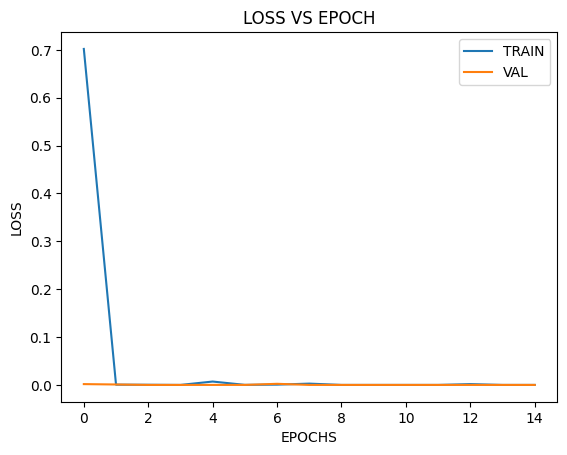

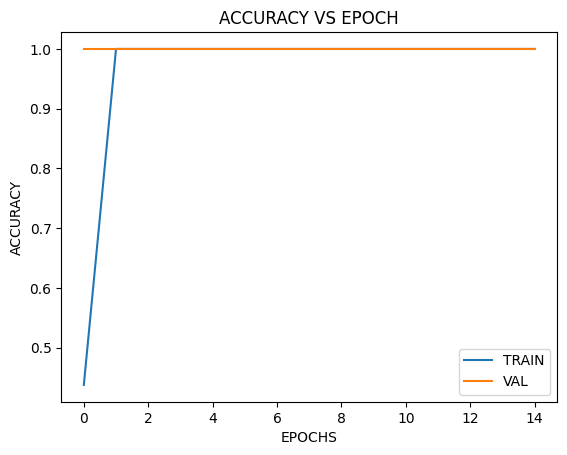

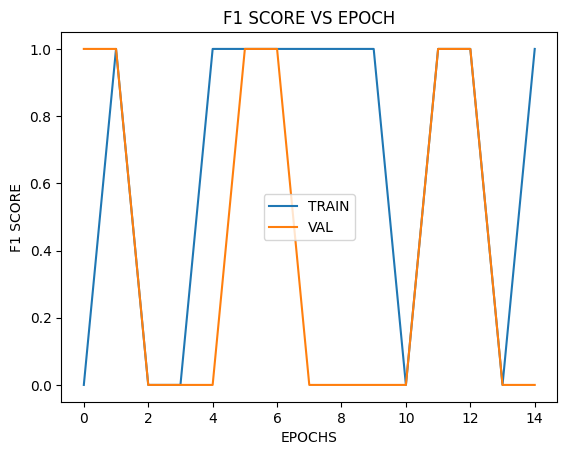

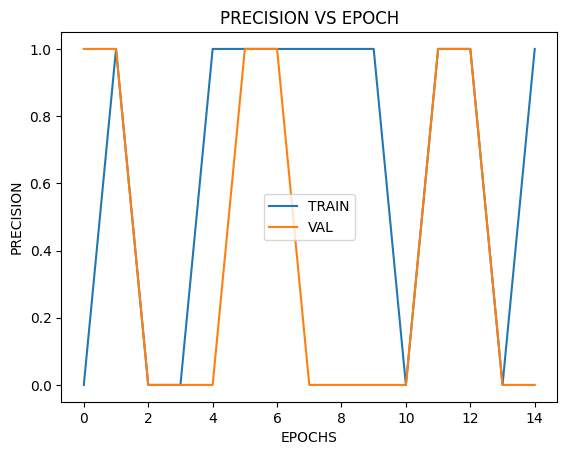

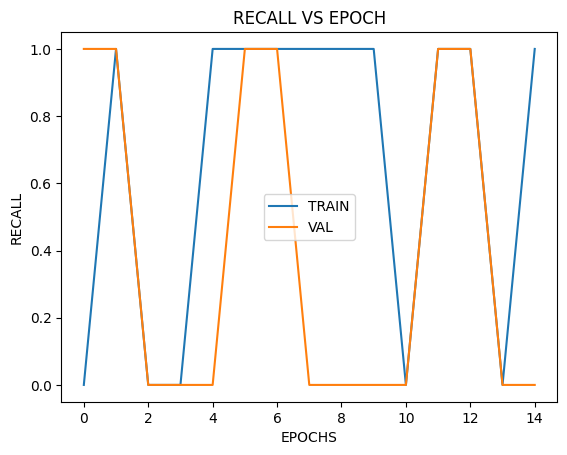

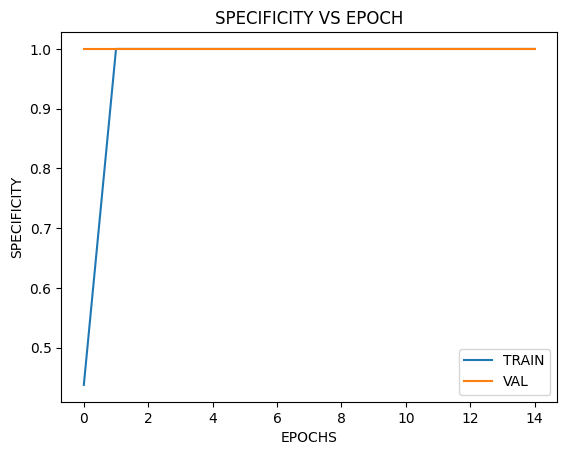

In [21]:
plt.plot(loss_history[0][::train_n_minibatches], label="TRAIN")
plt.plot(loss_history[1][::validation_n_minibatches], label="VAL")
plt.xlabel('EPOCHS')
plt.ylabel('LOSS')
plt.title("LOSS VS EPOCH")
plt.legend()
plt.savefig("loss_cnn_attn.pdf", format="pdf")
plt.show()

plt.plot(accuracy_history[0][::train_n_minibatches], label="TRAIN")
plt.plot(accuracy_history[1][::validation_n_minibatches], label="VAL")
plt.xlabel('EPOCHS')
plt.ylabel('ACCURACY')
plt.title("ACCURACY VS EPOCH")
plt.legend()
plt.savefig("acc_cnn_attn.pdf", format="pdf")
plt.show()

plt.plot(f1_history[0][::train_n_minibatches], label="TRAIN")
plt.plot(f1_history[1][::validation_n_minibatches], label="VAL")
plt.xlabel('EPOCHS')
plt.ylabel('F1 SCORE')
plt.title("F1 SCORE VS EPOCH")
plt.legend()
plt.savefig("f1_score_cnn_attn.pdf", format="pdf")
plt.show()

plt.plot(prec_history[0][::train_n_minibatches], label="TRAIN")
plt.plot(prec_history[1][::validation_n_minibatches], label="VAL")
plt.xlabel('EPOCHS')
plt.ylabel('PRECISION')
plt.title("PRECISION VS EPOCH")
plt.legend()
plt.show()

plt.plot(recall_history[0][::train_n_minibatches], label="TRAIN")
plt.plot(recall_history[1][::validation_n_minibatches], label="VAL")
plt.xlabel('EPOCHS')
plt.ylabel('RECALL')
plt.title("RECALL VS EPOCH")
plt.legend()
plt.show()

plt.plot(specifity_history[0][::train_n_minibatches], label="TRAIN")
plt.plot(specifity_history[1][::validation_n_minibatches], label="VAL")
plt.xlabel('EPOCHS')
plt.ylabel('SPECIFICITY')
plt.title("SPECIFICITY VS EPOCH")
plt.legend()
plt.show()



In [23]:
# device = "cuda"
model = CNN(250,1,len(characters), 128)
model.load_state_dict(torch.load(f"saved_models/{model_name}", map_location=device))


250 1 101 128


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [22]:
loss_history = [[], []]
prec_history = [[], []]
recall_history = [[], []]
accuracy_history = [[], []]
f1_history = [[], []]
specifity_history = [[], []]
BIL_history = []


with torch.no_grad():
    for batch_idx, (x, y) in enumerate(test_dataloader):
        model.eval()
        # x, y = x.to(device), y.to(device)
        y_pred = model(x)
        # Calculating Loss
        loss = criterion(y_pred, y.view(-1,1))
        loss_history[1].append(float(loss.detach()))
        # Calaculating Accuracy
        y_pred = y_pred.cpu().detach().numpy().tolist()
        y = y.cpu().detach().numpy().tolist()
        acc, rec, prec, f1, specificity_ = acc_recall_precision_f1(y_pred, y)
        accuracy_history[1].append(acc)
        recall_history[1].append(rec)
        prec_history[1].append(prec)
        f1_history[1].append(f1)
        specifity_history[1].append(specificity_)
# Saving the model progress

# Log for e+1th epoch
print(
    f"TEST LOSS : {sum(loss_history[1][-1:-1*test_n_minibatches-1:-1])/test_n_minibatches}",
    end=" ",
)
print(
    f"TEST ACCURACY : {sum(accuracy_history[1][-1:-test_n_minibatches-1:-1])/test_n_minibatches}", end=" ",
)
print(
    f"TEST RECALL : {sum(recall_history[1][-1:-test_n_minibatches-1:-1])/test_n_minibatches}", end=" ",
)
print(
    f"TEST PRECISION : {sum(prec_history[1][-1:-test_n_minibatches-1:-1])/test_n_minibatches}", end=" ",
)
print(
    f"TEST F1 : {sum(f1_history[1][-1:-test_n_minibatches-1:-1])/test_n_minibatches}", end=" ",
)
print(
    f"TEST SPECIFITY : {sum(specifity_history[1][-1:-test_n_minibatches-1:-1])/test_n_minibatches}"
)
print(
    "---------------------------------------------------------------------------------------------\n\n"
)

TEST LOSS : 0.022166699534261296 TEST ACCURACY : 0.9971250245724396 TEST RECALL : 0.6530797457571582 TEST PRECISION : 0.6608085970775175 TEST F1 : 0.6536553578130142 TEST SPECIFITY : 0.9989387734806973
---------------------------------------------------------------------------------------------




In [25]:
BIL_results(model, timer=True)

--- Model took 0.1328887939453125 seconds to predict ---
--- Model took 0.17711353302001953 seconds to predict ---
--- Model took 0.07469034194946289 seconds to predict ---
--- Model took 0.1710963249206543 seconds to predict ---
--- Model took 0.16743874549865723 seconds to predict ---
--- Model took 0.14758539199829102 seconds to predict ---
--- Model took 0.0731651782989502 seconds to predict ---
--- Model took 0.18715262413024902 seconds to predict ---
--- Model took 0.06096458435058594 seconds to predict ---
--- Model took 0.28731203079223633 seconds to predict ---
--- Model took 0.11514759063720703 seconds to predict ---
--- Model took 0.07899069786071777 seconds to predict ---
--- Model took 0.09360480308532715 seconds to predict ---
--- Model took 0.22263264656066895 seconds to predict ---
--- Model took 0.03439903259277344 seconds to predict ---
--- Model took 0.07230806350708008 seconds to predict ---
--- Model took 0.04729199409484863 seconds to predict ---
--- Model took 0.

((0.9297282159839898,
  0.8487321986800973,
  0.8487321986800973,
  0.8487321986800973,
  0.9301214338813835),
 (0.8881261271517674,
  0.8857242097950677,
  0.8828793488133283,
  0.8833175085462776,
  0.006015653096343506),
 (0.9721641091423736,
  0.9162519759286699,
  0.9208058353594998,
  0.9165830388519132,
  0.8791098768568529))

In [26]:
model = model.to('cpu')

def BIL_model(model, text):
    device = 'cpu'
    text = text.replace("\r","\n").replace("\t","\n")

    x = []
    offsets = []
    
    for pos, char in enumerate(text):
        if char in dlimit_final.keys():
            right = text[pos+1:pos+window_size+1]
            left = text[pos-window_size-1:pos-1]
            if len(right) == 0:
                right = "\n"+ " "*(window_size-1)
            # elif right.replace(".","")[0] == "\n":
            #     continue
            # elif right[0] == "\n":
            #     right = "\n"+ " "*(window_size-1)
            right = right + " "*(window_size-len(right))
            left = " "*(window_size-len(left)) + left

            x.append([left,char, right])
            offsets.append(pos)


    inputs = []
    for i in x:
        temp = []
        x_ = ''.join(i[0]) + ''.join(i[1]) + ''.join(i[2])
        for i in x_:
            if i in characters:
                temp.append(characters[i])

            else:
                temp.append(characters['UNK'])
            
        inputs.append(np.asarray(temp))

    inputs = torch.IntTensor(np.asarray(inputs))

    pred = model(inputs)

    pred = pred.cpu().detach().numpy().tolist()
    pred_offsets = []

    for each_pred in pred:
        pred_offsets.append(round(each_pred[0]))

    output = []
    start = 0

    for i,j in zip(offsets, pred_offsets):
        if j == 1:
            output.append(text[start:i+1])
            start = i+1

    return output


BIL_results(model, timer=True)


--- Model took 0.09986758232116699 seconds to predict ---
--- Model took 0.15744709968566895 seconds to predict ---
--- Model took 0.07796764373779297 seconds to predict ---
--- Model took 0.18886685371398926 seconds to predict ---
--- Model took 0.3275642395019531 seconds to predict ---
--- Model took 0.1402733325958252 seconds to predict ---
--- Model took 0.07038497924804688 seconds to predict ---
--- Model took 0.17907094955444336 seconds to predict ---
--- Model took 0.05816149711608887 seconds to predict ---
--- Model took 0.08940768241882324 seconds to predict ---
--- Model took 0.12546539306640625 seconds to predict ---
--- Model took 0.06530618667602539 seconds to predict ---
--- Model took 0.10515880584716797 seconds to predict ---
--- Model took 0.19706439971923828 seconds to predict ---
--- Model took 0.038080453872680664 seconds to predict ---
--- Model took 0.06831073760986328 seconds to predict ---
--- Model took 0.04536318778991699 seconds to predict ---
--- Model took 

((0.9289266670134693,
  0.8567892503536068,
  0.8567892503536068,
  0.8567892503536068,
  0.9292185129557974),
 (0.8815946037514708,
  0.8792432814710043,
  0.8760724274213697,
  0.8765568367951057,
  0.00626366095320694),
 (0.975035058931066,
  0.9263646413466893,
  0.9308698727015559,
  0.9266733044254551,
  0.8745299911050906))

In [49]:
PATH_IND = "./data/ILDC_expert (1)/ILDC_expert/annotation"

In [50]:
subpaths = []

In [51]:
import json

In [52]:
import os

for path, subdirs, files in os.walk(PATH_IND):
    for name in files:
        if(name == "user1.json"):
            subpaths.append(os.path.join(path, name))
            print(os.path.join(path, name))

./data/ILDC_expert (1)/ILDC_expert/annotation\1951_10.txt\user1.json
./data/ILDC_expert (1)/ILDC_expert/annotation\1951_30.txt\user1.json
./data/ILDC_expert (1)/ILDC_expert/annotation\1951_33.txt\user1.json
./data/ILDC_expert (1)/ILDC_expert/annotation\1951_35.txt\user1.json
./data/ILDC_expert (1)/ILDC_expert/annotation\1951_36.txt\user1.json
./data/ILDC_expert (1)/ILDC_expert/annotation\1951_40.txt\user1.json
./data/ILDC_expert (1)/ILDC_expert/annotation\1951_64.txt\user1.json
./data/ILDC_expert (1)/ILDC_expert/annotation\1951_80.txt\user1.json
./data/ILDC_expert (1)/ILDC_expert/annotation\1952_42.txt\user1.json
./data/ILDC_expert (1)/ILDC_expert/annotation\1952_60.txt\user1.json
./data/ILDC_expert (1)/ILDC_expert/annotation\1952_75.txt\user1.json
./data/ILDC_expert (1)/ILDC_expert/annotation\1953_14.txt\user1.json
./data/ILDC_expert (1)/ILDC_expert/annotation\1953_26.txt\user1.json
./data/ILDC_expert (1)/ILDC_expert/annotation\1953_57.txt\user1.json
./data/ILDC_expert (1)/ILDC_expert

In [53]:
len(subpaths)

56

In [ ]:
dataset_ind = (json.load(open(path, "r", encoding="utf8")))
print(dataset_ind)


In [14]:
len(subpaths)

0

In [55]:
import json


def print_json_tree(data, indent=0):
    if isinstance(data, dict):
        for key, value in data.items():
            print(f"{'  ' * indent}{key}:")
            print_json_tree(value, indent + 1)
    elif isinstance(data, list):
        for item in data:
            print_json_tree(item, indent)
    else:
        print(f"{'  ' * (indent + 1)}{data}")


# Example usage
with open(subpaths[0]) as json_file:
    json_data = json.load(json_file)
    print_json_tree(json_data)


_context:
  _types:
    ACCEPTED:
      _feature_types:
        sofa:
            _ref
    DocumentMetaData:
      _feature_types:
        sofa:
            _ref
    RANK1:
      _feature_types:
        sofa:
            _ref
    Rank2:
      _feature_types:
        sofa:
            _ref
    Rank3:
      _feature_types:
        sofa:
            _ref
    Rank4:
      _feature_types:
        sofa:
            _ref
    Rank5:
      _feature_types:
        sofa:
            _ref
    Sentence:
      _feature_types:
        sofa:
            _ref
    Sofa:
      _feature_types:
        sofaArray:
            _ref
    TagsetDescription:
      _feature_types:
        sofa:
            _ref
        tags:
            _ref
    Token:
      _feature_types:
        sofa:
            _ref
        parent:
            _ref
        lemma:
            _ref
        stem:
            _ref
        pos:
            _ref
        morph:
            _ref
        form:
            _ref
    Annotation:
      _

In [ ]:
dataset['_referenced_fss']['12']['sofaString']

In [45]:
dlimit_f = {}

In [46]:
def filter_delims(x):
    dataset = json.load(open(x, "r", encoding="utf8"))
    text = dataset['_referenced_fss']['12']['sofaString']
    dlimit = {}
    for pos, char in enumerate(text):
        if not char.isalnum():
            dlimit[char]=1
    return dlimit

for i in subpaths:
    dlimit_f.update(filter_delims(i)) 

In [47]:
dlimit_f

{' ': 1, '(': 1, '.': 1, ')': 1, ',': 1, '-': 1, '\n': 1, '?': 1, '/': 1}

In [48]:
annotations_ind = []

In [50]:
for i in subpaths:
    dataset = json.load(open(i, "r", encoding="utf8"))
    annotations_ind.append(dataset['_views']['_InitialView']['Sentence'])

In [53]:
len(annotations_ind)

56

In [15]:
annotations_ind

[{'sofa': 12, 'end': 294},
 {'sofa': 12, 'begin': 295, 'end': 347},
 {'sofa': 12, 'begin': 348, 'end': 350},
 {'sofa': 12, 'begin': 351, 'end': 416},
 {'sofa': 12, 'begin': 417, 'end': 429},
 {'sofa': 12, 'begin': 431, 'end': 573},
 {'sofa': 12, 'begin': 574, 'end': 628},
 {'sofa': 12, 'begin': 629, 'end': 878},
 {'sofa': 12, 'begin': 880, 'end': 1039},
 {'sofa': 12, 'begin': 1040, 'end': 1380},
 {'sofa': 12, 'begin': 1382, 'end': 1441},
 {'sofa': 12, 'begin': 1442, 'end': 1563},
 {'sofa': 12, 'begin': 1564, 'end': 1704},
 {'sofa': 12, 'begin': 1706, 'end': 1807},
 {'sofa': 12, 'begin': 1808, 'end': 2087},
 {'sofa': 12, 'begin': 2088, 'end': 2241},
 {'sofa': 12, 'begin': 2243, 'end': 2538},
 {'sofa': 12, 'begin': 2539, 'end': 2723},
 {'sofa': 12, 'begin': 2724, 'end': 3060},
 {'sofa': 12, 'begin': 3062, 'end': 3355},
 {'sofa': 12, 'begin': 3357, 'end': 3466},
 {'sofa': 12, 'begin': 3467, 'end': 4221},
 {'sofa': 12, 'begin': 4223, 'end': 4529},
 {'sofa': 12, 'begin': 4530, 'end': 4650},

In [80]:
def annot_gen(x):
    dataset = json.load(open(x, "r", encoding="utf8"))
    annotations_ind = (dataset['_views']['_InitialView']['Sentence'])
    final_annot = []
    for p in annotations_ind:
            list = {}
            if(len(p)==2):
                list['begin'] = 0
                list['end'] = p['end']
            else:
                list['begin'] = p['begin']
                list['end'] = p['end']
            final_annot.append(list)
    return final_annot
    
            

       

In [81]:
print(annot_gen(subpaths[0]))

[{'begin': 0, 'end': 294}, {'begin': 295, 'end': 347}, {'begin': 348, 'end': 350}, {'begin': 351, 'end': 416}, {'begin': 417, 'end': 429}, {'begin': 431, 'end': 573}, {'begin': 574, 'end': 628}, {'begin': 629, 'end': 878}, {'begin': 880, 'end': 1039}, {'begin': 1040, 'end': 1380}, {'begin': 1382, 'end': 1441}, {'begin': 1442, 'end': 1563}, {'begin': 1564, 'end': 1704}, {'begin': 1706, 'end': 1807}, {'begin': 1808, 'end': 2087}, {'begin': 2088, 'end': 2241}, {'begin': 2243, 'end': 2538}, {'begin': 2539, 'end': 2723}, {'begin': 2724, 'end': 3060}, {'begin': 3062, 'end': 3355}, {'begin': 3357, 'end': 3466}, {'begin': 3467, 'end': 4221}, {'begin': 4223, 'end': 4529}, {'begin': 4530, 'end': 4650}, {'begin': 4651, 'end': 4987}, {'begin': 4989, 'end': 5148}, {'begin': 5149, 'end': 5224}, {'begin': 5225, 'end': 5375}, {'begin': 5376, 'end': 5611}, {'begin': 5612, 'end': 5725}, {'begin': 5727, 'end': 6000}, {'begin': 6001, 'end': 6376}, {'begin': 6379, 'end': 6775}, {'begin': 6776, 'end': 6987}

In [ ]:
window_size = 6

def dataset_gen(x, window_size=10):
    dataset = json.load(open(x, "r", encoding="utf8"))
    x_ind = []
    y_ind = []
    fin_annot = []


    text = dataset['_referenced_fss']['12']['sofaString']
    ends = []

    fin_annot = annot_gen(x)
   
    for loc in fin_annot:
        ends.append(loc['end'])

    for pos, char in enumerate(text):
        if char in dlimit_f.keys():
            right = text[pos+1:pos+window_size+1]
            left = text[pos-window_size-1:pos-1]

            if len(right) == 0:
                right = "\n"+ " "*(window_size-1)

            right = right + " "*(window_size-len(right))
            left = " "*(window_size-len(left)) + left

            x_ind.append([left,char,right])

            if pos+1 in ends:
                y_ind.append(1) # setence eneded if 1

            else:
                y_ind.append(0) 
    return x_ind, y_ind
test_x_ind = []
test_y_ind = []

for paths in subpaths:
    x_ind,y_ind = dataset_gen(paths, window_size=window_size)
    test_x_ind = test_x_ind + x_ind
    test_y_ind = test_y_ind + y_ind

In [85]:
test_y_ind

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [83]:

class SBD_dataset(Dataset):
    def __init__(self, x, y, char_dict):
        self.x = x
        self.y = y
        self.len = len(x)
        self.char_dict = char_dict

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        x_ = ''.join(self.x[idx][0]) + ''.join(self.x[idx][1])+''.join(self.x[idx][2])
        
        x = []

        for i in x_:
            if i in self.char_dict:
                x.append(self.char_dict[i])

            else:
                x.append(self.char_dict['UNK'])

        return torch.IntTensor(x), self.y[idx]


batch_size = 32

test_ind_dataset = SBD_dataset(test_x_ind, torch.FloatTensor(test_y_ind), characters)
test_ind_dataloader = DataLoader(test_ind_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [86]:
loss_history = [[], []]
prec_history = [[], []]
recall_history = [[], []]
accuracy_history = [[], []]
f1_history = [[], []]
specifity_history = [[], []]
BIL_history = []


with torch.no_grad():
    for batch_idx, (x, y) in enumerate(test_ind_dataloader):
        model.eval()
        # x, y = x.to(device), y.to(device)
        y_pred_ind = model(x)
        # Calculating Loss
        loss = criterion(y_pred_ind, y.view(-1,1))
        loss_history[1].append(float(loss.detach()))
        # Calaculating Accuracy
        y_pred_ind = y_pred_ind.cpu().detach().numpy().tolist()
        y = y.cpu().detach().numpy().tolist()
        acc, rec, prec, f1, specificity_ = acc_recall_precision_f1(y_pred, y)
        accuracy_history[1].append(acc)
        recall_history[1].append(rec)
        prec_history[1].append(prec)
        f1_history[1].append(f1)
        specifity_history[1].append(specificity_)
# Saving the model progress

# Log for e+1th epoch
print(
    f"TEST LOSS : {sum(loss_history[1][-1:-1*test_n_minibatches-1:-1])/test_n_minibatches}",
    end=" ",
)
print(
    f"TEST ACCURACY : {sum(accuracy_history[1][-1:-test_n_minibatches-1:-1])/test_n_minibatches}", end=" ",
)
print(
    f"TEST RECALL : {sum(recall_history[1][-1:-test_n_minibatches-1:-1])/test_n_minibatches}", end=" ",
)
print(
    f"TEST PRECISION : {sum(prec_history[1][-1:-test_n_minibatches-1:-1])/test_n_minibatches}", end=" ",
)
print(
    f"TEST F1 : {sum(f1_history[1][-1:-test_n_minibatches-1:-1])/test_n_minibatches}", end=" ",
)
print(
    f"TEST SPECIFITY : {sum(specifity_history[1][-1:-test_n_minibatches-1:-1])/test_n_minibatches}"
)
print(
    "---------------------------------------------------------------------------------------------\n\n"
)

TEST LOSS : 0.07831412312467907 TEST ACCURACY : 0.9114962158443091 TEST RECALL : 0.034450560251621784 TEST PRECISION : 0.02761942205622174 TEST F1 : 0.029191122094601587 TEST SPECIFITY : 0.9373818980924417
---------------------------------------------------------------------------------------------




In [87]:
BIL_results(model, timer=True)

--- Model took 0.07621645927429199 seconds to predict ---
--- Model took 0.14889287948608398 seconds to predict ---
--- Model took 0.07437252998352051 seconds to predict ---
--- Model took 0.15045404434204102 seconds to predict ---
--- Model took 0.3293638229370117 seconds to predict ---
--- Model took 0.16378569602966309 seconds to predict ---
--- Model took 0.07427191734313965 seconds to predict ---
--- Model took 0.1927652359008789 seconds to predict ---
--- Model took 0.052753448486328125 seconds to predict ---
--- Model took 0.08820295333862305 seconds to predict ---
--- Model took 0.1277930736541748 seconds to predict ---
--- Model took 0.07138657569885254 seconds to predict ---
--- Model took 0.10815691947937012 seconds to predict ---
--- Model took 0.21860551834106445 seconds to predict ---
--- Model took 0.05420517921447754 seconds to predict ---
--- Model took 0.0720982551574707 seconds to predict ---
--- Model took 0.047304391860961914 seconds to predict ---
--- Model took 0

((0.9289266670134693,
  0.8567892503536068,
  0.8567892503536068,
  0.8567892503536068,
  0.9292185129557974),
 (0.8815946037514708,
  0.8792432814710043,
  0.8760724274213697,
  0.8765568367951057,
  0.00626366095320694),
 (0.975035058931066,
  0.9263646413466893,
  0.9308698727015559,
  0.9266733044254551,
  0.8745299911050906))

In [41]:
BIL_results(model, timer=True)

--- Model took 0.4021756649017334 seconds to predict ---
--- Model took 0.18545031547546387 seconds to predict ---
--- Model took 0.10407423973083496 seconds to predict ---
--- Model took 0.18810534477233887 seconds to predict ---
--- Model took 0.17591357231140137 seconds to predict ---
--- Model took 0.19122838973999023 seconds to predict ---
--- Model took 0.10336518287658691 seconds to predict ---
--- Model took 0.281890869140625 seconds to predict ---
--- Model took 0.08387565612792969 seconds to predict ---
--- Model took 0.11838555335998535 seconds to predict ---
--- Model took 0.20112872123718262 seconds to predict ---
--- Model took 0.1304152011871338 seconds to predict ---
--- Model took 0.14498209953308105 seconds to predict ---
--- Model took 0.3529939651489258 seconds to predict ---
--- Model took 0.06052803993225098 seconds to predict ---
--- Model took 0.09133315086364746 seconds to predict ---
--- Model took 0.06245875358581543 seconds to predict ---
--- Model took 0.48

((0.9257256055433559,
  0.8045138299677583,
  0.8045138299677583,
  0.8045138299677583,
  0.9261421433999633),
 (0.8877311413432993,
  0.884269472255218,
  0.8823262897863308,
  0.8826404938407504,
  0.006167537095560836),
 (0.9667184750101382,
  0.8722796454338154,
  0.8762939080264721,
  0.8725910892806594,
  0.8715377816582154))

In [58]:
from luima_sbd import *
import argparse
import codecs
import luima_sbd.config as config
import luima_sbd.server_utils as server_utils
import sys
import luima_sbd.sbd_utils as sbd_utils

In [59]:
def CRF_model(text):
    return sbd_utils.text2sentences(text)
    


In [60]:
results = {}

In [61]:
def check_range_new(pointer_start, pointer_end, ranges):
    intersection_dict = {}
    for i in ranges:
        if pointer_start>=i['begin'] and pointer_end>=i['end']:
            intersection_dict[str(i['begin'])+'-'+str(i['end'])] = [i['end'] - pointer_start, abs(i['begin']-pointer_start)]

        if pointer_start<=i['begin'] and pointer_end>=i['end']:
            intersection_dict[str(i['begin'])+'-'+str(i['end'])] = [i['end'] - i['begin'], abs(i['begin']-pointer_start)]
        
        if pointer_start>=i['begin'] and pointer_end<=i['end']:
            intersection_dict[str(i['begin'])+'-'+str(i['end'])] = [pointer_end - pointer_start, abs(i['begin']-pointer_start)]

        if pointer_start<=i['begin'] and pointer_end<=i['end']:
            intersection_dict[str(i['begin'])+'-'+str(i['end'])] = [pointer_end - i['begin'], abs(i['begin']-pointer_start)]

    max_intersection_key = None
    max_intersection_len = -1
    max_intersection_start_dist = 1000000
    
    for i in intersection_dict.keys():
        if intersection_dict[i][0]>max_intersection_len or (intersection_dict[i][0]==max_intersection_len and max_intersection_start_dist<intersection_dict[i][1]):
            max_intersection_len =  intersection_dict[i][0]
            max_intersection_key = i
            max_intersection_start_dist = intersection_dict[i][1]

    return max_intersection_key


In [62]:
for path_ in subpaths:
    dataset = json.load(open(path_, "r", encoding="utf8"))
    results[path_] = []
    x = dataset['_referenced_fss']['12']['sofaString']
    annotations = []
    y = []
    for sentence in dataset['_views']['_InitialView']['Sentence']:
        if(len(sentence )== 2):
            y.append(dataset['_referenced_fss']['12']['sofaString'][0:sentence['end']])
            annotations.append({'begin':0,'end':sentence['end']})
        else:
            y.append(dataset['_referenced_fss']['12']['sofaString'][sentence['begin']:sentence['end']])
            annotations.append({'begin':sentence['begin'],'end':sentence['end']})

    pred = CRF_model(x.replace("\r","\n").replace("\t","\n"))

    pointer = 0
    mappings = []
    filtred_pred = []

    for pred_sentences in pred:


            padding = 0
            pointer = pointer + dataset['_referenced_fss']['12']['sofaString'][pointer:pointer+len(pred_sentences)+10].find(pred_sentences[:4])
        
            ending = dataset['_referenced_fss']['12']['sofaString'][pointer:pointer+len(pred_sentences)+10].find(pred_sentences[-4:])
           
            maped = check_range_new(pointer, pointer+ending+4, annotations)

           
            pointer += ending+4
    
            pred_sentences = pred_sentences.replace("\n"," ").replace("\r"," ").replace("\t"," ")
           
    
            if maped is not None :
              
                mappings.append(dataset['_referenced_fss']['12']['sofaString'][int(maped.split('-')[0]):int(maped.split('-')[1])])
                filtred_pred.append(pred_sentences)
               
                results[path_].append(BIL_TF_PN(mappings[-1], filtred_pred[-1]))

    

In [63]:
len(results)

56

In [64]:

for paths in results:
    print(paths)
    B = []
    I = []
    L = []

    for i in results[paths]:
        B.append(i[0])
        I.append(i[1])
        L.append(i[-1])


    print(f"B : {BIL_acc_recall_precision_f1(B)}")
    print(f"I : {BIL_acc_recall_precision_f1(I)}")
    print(f"L : {BIL_acc_recall_precision_f1(L)}\n")

       
        

./data/ILDC_expert (1)/ILDC_expert/annotation\1951_10.txt\user1.json
B : (0.9383180172653858, 0.8947368421052632, 0.8947368421052632, 0.8947368421052632, 0.9441659704817598)
I : (0.9488304093567251, 0.9473684210526315, 0.9473684210526315, 0.9473684210526315, 0.001594896331738437)
L : (0.9620308346624136, 0.9122807017543859, 0.9122807017543859, 0.9122807017543859, 0.9444869750132908)

./data/ILDC_expert (1)/ILDC_expert/annotation\1951_30.txt\user1.json
B : (0.9555555555555556, 0.9111111111111111, 0.9111111111111111, 0.9111111111111111, 0.9592592592592594)
I : (0.9362752823745732, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.003138214442562269)
L : (0.9959365079365079, 0.9555555555555556, 0.9555555555555556, 0.9555555555555556, 0.9292698412698412)

./data/ILDC_expert (1)/ILDC_expert/annotation\1951_33.txt\user1.json
B : (0.9883720930232558, 0.9767441860465116, 0.9767441860465116, 0.9767441860465116, 0.9883720930232558)
I : (0.9771394328845368, 0.9767441860465116, 0.97674

In [65]:
len(results)

56

In [69]:
sum_b=0
sum_i = 0
sum_b_acc = 0
sum_i_acc=0
sum_b_rec =0
sum_i_rec=0
sum_b_prec =0
sum_i_prec =0
for paths in results:
        B = []
        I = []
        L = []

        for i in results[paths]:
            B.append(i[0])
            I.append(i[1])
            L.append(i[-1])

        sum_b= sum_b + BIL_acc_recall_precision_f1(B)[3]
        sum_i = sum_i + BIL_acc_recall_precision_f1(L)[3]
        sum_b_acc = sum_b_acc + BIL_acc_recall_precision_f1(B)[0]
        sum_i_acc = sum_i_acc + BIL_acc_recall_precision_f1(L)[0]
        sum_b_rec= sum_b_rec + BIL_acc_recall_precision_f1(B)[1]
        sum_i_rec= sum_i_rec + BIL_acc_recall_precision_f1(L)[1]
        sum_b_prec= sum_b_prec + BIL_acc_recall_precision_f1(B)[2]
        sum_b_prec= sum_b_prec + BIL_acc_recall_precision_f1(L)[2]

        

avg_i = sum_i/56
avg_b = sum_b/56

avg_i_acc = sum_i_acc/56
avg_b_acc = sum_b_acc/56

avg_i_rec = sum_i_rec/56
avg_b_rec = sum_b_rec/56

avg_i_prec = sum_i_prec/56
avg_b_prec = sum_b_prec/56

ans = (avg_i+avg_b)/2

ans2 = (avg_i_acc+avg_b_acc)/2

ans3 = (avg_i_rec+avg_b_rec)/2

ans4 = (avg_b_prec+avg_i_prec)/2

print("Indian Legal Dataset: Hybrid")
print("F1:")
print("B")
print(avg_b)
print("I")
print(avg_i)
print("ans")
print(ans)

print("ACC:")
print("B")
print(avg_b_acc)
print("I")
print(avg_i_acc)
print("ans")
print(ans2)

print("Indian Legal Dataset: Hybrid")
print("Recall:")
print("B")
print(avg_b_rec)
print("I")
print(avg_i_rec)
print("ans")
print(ans3)

print("Indian Legal Dataset: Hybrid")
print("Precision:")
print("B")
print(avg_b_prec)
print("I")
print(avg_i_prec)
print("ans")
print(ans4)



Indian Legal Dataset: Hybrid
F1:
B
0.8725744899196828
I
0.8983459257108918
ans
0.8854602078152873
ACC:
B
0.9315561762195506
I
0.9566454445938216
ans
0.9441008104066861
Indian Legal Dataset: Hybrid
Recall:
B
0.8725744899196828
I
0.8982240030365665
ans
0.8853992464781246
Indian Legal Dataset: Hybrid
Precision:
B
1.7750061474814376
I
0.0
ans
0.8875030737407188


In [ ]:
for paths in results:
    print(paths)
    B = []
    I = []
    L = []

    for i in results[paths]:
        B.append(i[0])
        I.append(i[1])
        L.append(i[-1])


    print(f"B : {acc_recall_precision_f1(B)}")
    print(f"I : {acc_recall_precision_f1(I)}")
    print(f"L : {acc_recall_precision_f1(L)}\n")